In [3]:
import numpy as np
import tensorflow as tf
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [35]:
import utils.cleaningDataset as cleanDS
import utils.dataManipulation as maniDS

# Choose the Dataset

In [6]:
data_twoPeople = [
    'model/point_history_classifier/datasets/point_history.csv', 
    'model/point_history_classifier/datasets/point_history_xinyang.csv'
    ]
badSampleIdxList_twoPeople = [
    "badSampleIdxList_yipeng.txt", 
    "badSampleIdxList_xinyang.txt"
    ]
# model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_2P.hdf5'
# model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_LR_random_10.hdf5'
# tflite_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_LR_random_10.tflite'
model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_LR_random_22.hdf5'
tflite_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_LR_random_22.tflite'
# model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_LR_random_18.hdf5'
# tflite_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_LR_random_18.tflite'
# label_names = ["Clockwise", "Counter Clockwise", "Checkmark", "Right", "Left", "None"]
label_names = ["Clockwise", "Counter Clockwise", "Checkmark", "Cross", "Right", "Left", "None"]

should_we_delete_cross = False

# How many classes?

In [7]:
NUM_CLASSES = 7

# Input Length

In [8]:
TIME_STEPS = 30 #16 or 30
TIME_STEPS_AFTER_EXPAND = 45 #16 or 30
DIMENSION = 2

# Load Data
Call the function in cleaningDataset.py to delete the bad samples screened in delete_polluted_data.py.

In [9]:
X_dataset, y_dataset = cleanDS.loadDataset(
    data_twoPeople, 
    badSampleIdxList_twoPeople, 
    TIME_STEPS, 
    DIMENSION, 
    teleportation_threshold=0.2)
X_dataset.shape, y_dataset.shape

original shape =  (2409, 60)
original shape =  (2520, 60)


((4183, 60), (4183,))

# Manipulate Data

In [10]:
X_dataset, y_dataset = maniDS.addGaussian(X_dataset, y_dataset, mu=0, sigma=0.005)
X_dataset.shape, y_dataset.shape

((4183, 60), (4183,))

Create the Transformation Function H

In [11]:
"""
CCW, CW: rotation, scale, translate
check: scale, translate
cross: rotation, scale, translate
right, left: scale, translate
"""
H_dict = maniDS.generateTransitionMatrixH(
    CCW_n_CW_dup_times = 4,          # number of fake copies by duplicating original samples
    cross_dup_times = 6,             # number of fake copies by duplicating original samples
    check_dup_times = 4,             # number of fake copies by duplicating original samples
    left_n_right_dup_times = 4      # number of fake copies by duplicating original samples
    ) 
X_dataset, y_dataset = maniDS.transformDataset(X_dataset, y_dataset, H_dict)
X_dataset.shape, y_dataset.shape



((21556, 60), (21556,))

In [12]:
x = X_dataset[:, ::2]
y = X_dataset[:, 1::2]

dx = x[:, 1:] - x[:, :-1]
dy = y[:, 1:] - y[:, :-1]

np.mean(np.sqrt(dx * dx + dy * dy))

0.027789798868677575

Delete the Cross Class

In [13]:
maniDS.briefOfY(y_dataset, label_names)

{'Clockwise': 3995, 'Counter Clockwise': 3790, 'Checkmark': 3540, 'Cross': 3846, 'Right': 2965, 'Left': 3420, 'None': 0}


# Add NoneType Data

random_walk_data= (4500, 60)
984 random_walk_data


(4500, 60)

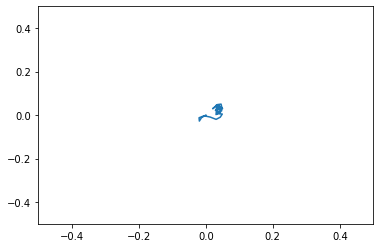

In [14]:
nonetype_label = len(label_names)-1

NoneTypeX_dataset, NoneTypey_dataset = maniDS.createNoneTypeData(
    TIME_STEPS, 
    nonetype_label = nonetype_label, 
    random_walking = 2000,
    sudden_points = 500,
    stop_moving = 2000)

maniDS.display(NoneTypeX_dataset, "random_walk_data")

NoneTypeX_dataset.shape

Add all nonetype data into main dataset

In [15]:
X_dataset, y_dataset = maniDS.appendTwoDatasets(X_dataset, NoneTypeX_dataset, y_dataset, NoneTypey_dataset)
maniDS.briefOfY(y_dataset, label_names)

{'Clockwise': 3995, 'Counter Clockwise': 3790, 'Checkmark': 3540, 'Cross': 3846, 'Right': 2965, 'Left': 3420, 'None': 4500}


**Padding all the gestures with None gesture in the front and end**

In [16]:

# X_dataset_w_randomSamples = maniDS.addRandomSamplesBeforeAfter_v1(X_dataset, 8, 7)
X_dataset_w_randomSamples = maniDS.addRandomSamplesBeforeAfter_v2(X_dataset, 45, 22, 22)
# X_dataset_w_randomSamples2 = maniDS.addRandomSamplesBeforeAfter_v2(X_dataset, 45, 22, 22)
# X_dataset_w_randomSamples1 = maniDS.addRandomSamplesBeforeAfter_v2(X_dataset, 45, 18, 18)
# X_dataset_w_randomSamples2 = maniDS.addRandomSamplesBeforeAfter_v2(X_dataset, 45, 18, 18)

# X_dataset_w_randomSamples, y_dataset = maniDS.appendTwoDatasets(X_dataset_w_randomSamples1, X_dataset_w_randomSamples2, y_dataset, y_dataset)

print(X_dataset_w_randomSamples.shape)
y_dataset

(26056, 90)


array([1, 1, 1, ..., 6, 6, 6])

X_dataset_expand= (26056, 90)
label Right
1975 X_dataset_expand
X_dataset_expand= (26056, 60)
label Right
1975 X_dataset_expand


1975

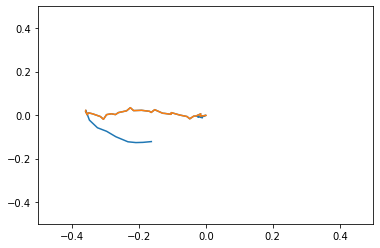

In [17]:
idx = maniDS.display(X_dataset_w_randomSamples, "X_dataset_expand", y_dataset, label_names)
idx = idx % X_dataset.shape[0]
maniDS.display(X_dataset, "X_dataset_expand", y_dataset, label_names, idx=idx)

In [18]:
X_dataset = X_dataset_w_randomSamples

In [19]:
maniDS.briefOfY(y_dataset, label_names)

{'Clockwise': 3995, 'Counter Clockwise': 3790, 'Checkmark': 3540, 'Cross': 3846, 'Right': 2965, 'Left': 3420, 'None': 4500}


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

Print the Train Set Info

In [21]:
maniDS.briefOfY(y_train, label_names)
y_train.shape

{'Clockwise': 2999, 'Counter Clockwise': 2827, 'Checkmark': 2676, 'Cross': 2837, 'Right': 2216, 'Left': 2588, 'None': 3399}


(19542,)

# モデル構築

In [22]:
use_lstm = True
model = None

TIME_STEPS = TIME_STEPS_AFTER_EXPAND

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.1), #0.2
        tf.keras.layers.LSTM(18, input_shape=[TIME_STEPS, DIMENSION]), # 16 previous
        tf.keras.layers.Dropout(0.2), #0.5
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2), #0.2
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dropout(0.5), #0.5
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [23]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 45, 2)             0         
                                                                 
 dropout (Dropout)           (None, 45, 2)             0         
                                                                 
 lstm (LSTM)                 (None, 18)                1512      
                                                                 
 dropout_1 (Dropout)         (None, 18)                0         
                                                                 
 dense (Dense)               (None, 20)                380       
                                                                 
 dense_1 (Dense)             (None, 7)                 147       
                                                                 
Total params: 2,039
Trainable params: 2,039
Non-trainabl

In [24]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=2, save_weights_only=False)
# 早期打ち切り用コールバック
# es_callback = tf.keras.callbacks.EarlyStopping(patience=1000, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=500, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [25]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [27]:
model.fit(
    X_train,
    y_train,
    epochs=2000,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/2000
37/39 [===========================>..] - ETA: 0s - loss: 1.2586 - accuracy: 0.5212
Epoch 1: saving model to model/point_history_classifier\point_history_classifier_LSTM_LR_random_22.hdf5
39/39 [==============================] - 1s 35ms/step - loss: 1.2579 - accuracy: 0.5214 - val_loss: 1.2169 - val_accuracy: 0.5184
Epoch 2/2000
37/39 [===========================>..] - ETA: 0s - loss: 1.2513 - accuracy: 0.5249
Epoch 2: saving model to model/point_history_classifier\point_history_classifier_LSTM_LR_random_22.hdf5
39/39 [==============================] - 1s 30ms/step - loss: 1.2508 - accuracy: 0.5245 - val_loss: 1.2204 - val_accuracy: 0.5181
Epoch 3/2000
38/39 [============================>.] - ETA: 0s - loss: 1.2518 - accuracy: 0.5219
Epoch 3: saving model to model/point_history_classifier\point_history_classifier_LSTM_LR_random_22.hdf5
39/39 [==============================] - 1s 30ms/step - loss: 1.2519 - accuracy: 0.5221 - val_loss: 1.2094 - val_accuracy: 0.5223
Epoch 4/20

In [28]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [29]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.02957361 0.03372926 0.34945762 0.2640298  0.03282378 0.23917747
 0.05120845]
2


# 混同行列

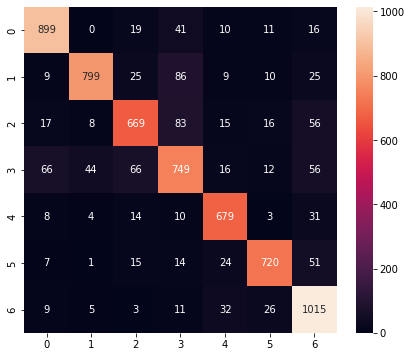

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       996
           1       0.93      0.83      0.88       963
           2       0.82      0.77      0.80       864
           3       0.75      0.74      0.75      1009
           4       0.86      0.91      0.89       749
           5       0.90      0.87      0.88       832
           6       0.81      0.92      0.86      1101

    accuracy                           0.85      6514
   macro avg       0.85      0.85      0.85      6514
weighted avg       0.85      0.85      0.85      6514



In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [33]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [34]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open(tflite_save_path, 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\linyi\AppData\Local\Temp\tmpxpbl76lx\assets


INFO:tensorflow:Assets written to: C:\Users\linyi\AppData\Local\Temp\tmpxpbl76lx\assets


15488